In [7]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [8]:
!pip install deepforest


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
annotations_path = "/Users/ishaangosain/Desktop/pipeline/annotations"
images_path = "/Users/ishaangosain/Desktop/pipeline/data"


In [2]:
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch

/Users/ishaangosain/miniforge3/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
model = main.deepforest()
model.use_release()

Reading config file: /Users/ishaangosain/miniforge3/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /Users/ishaangosain/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:16<00:00, 8.37MB/s] 
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

Reading config file: /Users/ishaangosain/miniforge3/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


model.safetensors:   0%|          | 0.00/129M [00:00<?, ?B/s]

In [7]:
#Set the path for a georeferenced image you want to predict tree crowns

# !wget -O data/hole_17_ortho_utm.tif https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
# raster_path = "hole_17_ortho_utm.tif"

# raster_path_test = "/content/drive/MyDrive/test/RGB/2018_SJER_3_252000_4104000_image_628.tif"

raster_path_test= "/Users/ishaangosain/Desktop/pipeline/data/redwood_area_04.tif"


In [8]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path_test, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=10)

Predicting: |          | 0/? [00:00<?, ?it/s]

435 predictions in overlapping windows, applying non-max supression
267 predictions kept after non-max suppression


In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import cv2
from deepforest import main

In [ ]:
shapefile_path = "/content/drive/MyDrive/test/NEON_trait_polygons.shp"
gdf = gpd.read_file(shapefile_path)

print("Columns:", gdf.columns.tolist())
print(gdf.iloc[0])

Columns: ['crwnPID', 'siteID', 'plotID', 'taxonID', 'cnpyPst', 'geometry']
crwnPID                                       TREE.00126.2020
siteID                                                   TREE
plotID                                               TREE_055
taxonID                                                  ACRU
cnpyPst                                      Partially shaded
geometry    POLYGON ((-89.59400297011346 45.49205284801213...
Name: 0, dtype: object


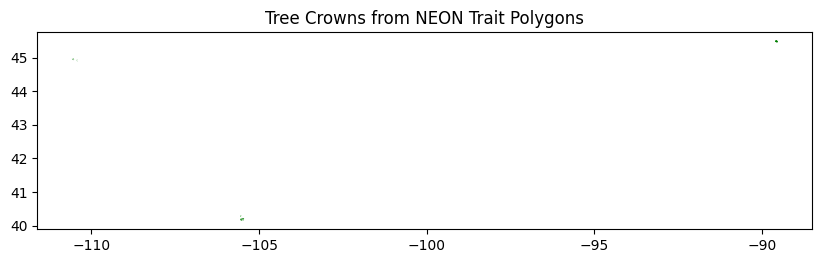

In [ ]:
gdf.plot(figsize=(10, 10), edgecolor='green')
plt.title("Tree Crowns from NEON Trait Polygons")
plt.show()

In [ ]:
gdf["xmin"] = gdf.geometry.bounds.minx
gdf["ymin"] = gdf.geometry.bounds.miny
gdf["xmax"] = gdf.geometry.bounds.maxx
gdf["ymax"] = gdf.geometry.bounds.maxy

# Use a placeholder or actual image path
image_path = "/content/drive/MyDrive/test/RGB/2018_SJER_3_252000_4104000_image_628.tif"

df = pd.DataFrame({
    "image_path": image_path,
    "xmin": gdf["xmin"],
    "ymin": gdf["ymin"],
    "xmax": gdf["xmax"],
    "ymax": gdf["ymax"],
    "label": "Tree"
})

df.to_csv("/content/drive/MyDrive/test/deepforest_annotations.csv", index=False)
print("✅ DeepForest annotations saved.")

✅ DeepForest annotations saved.


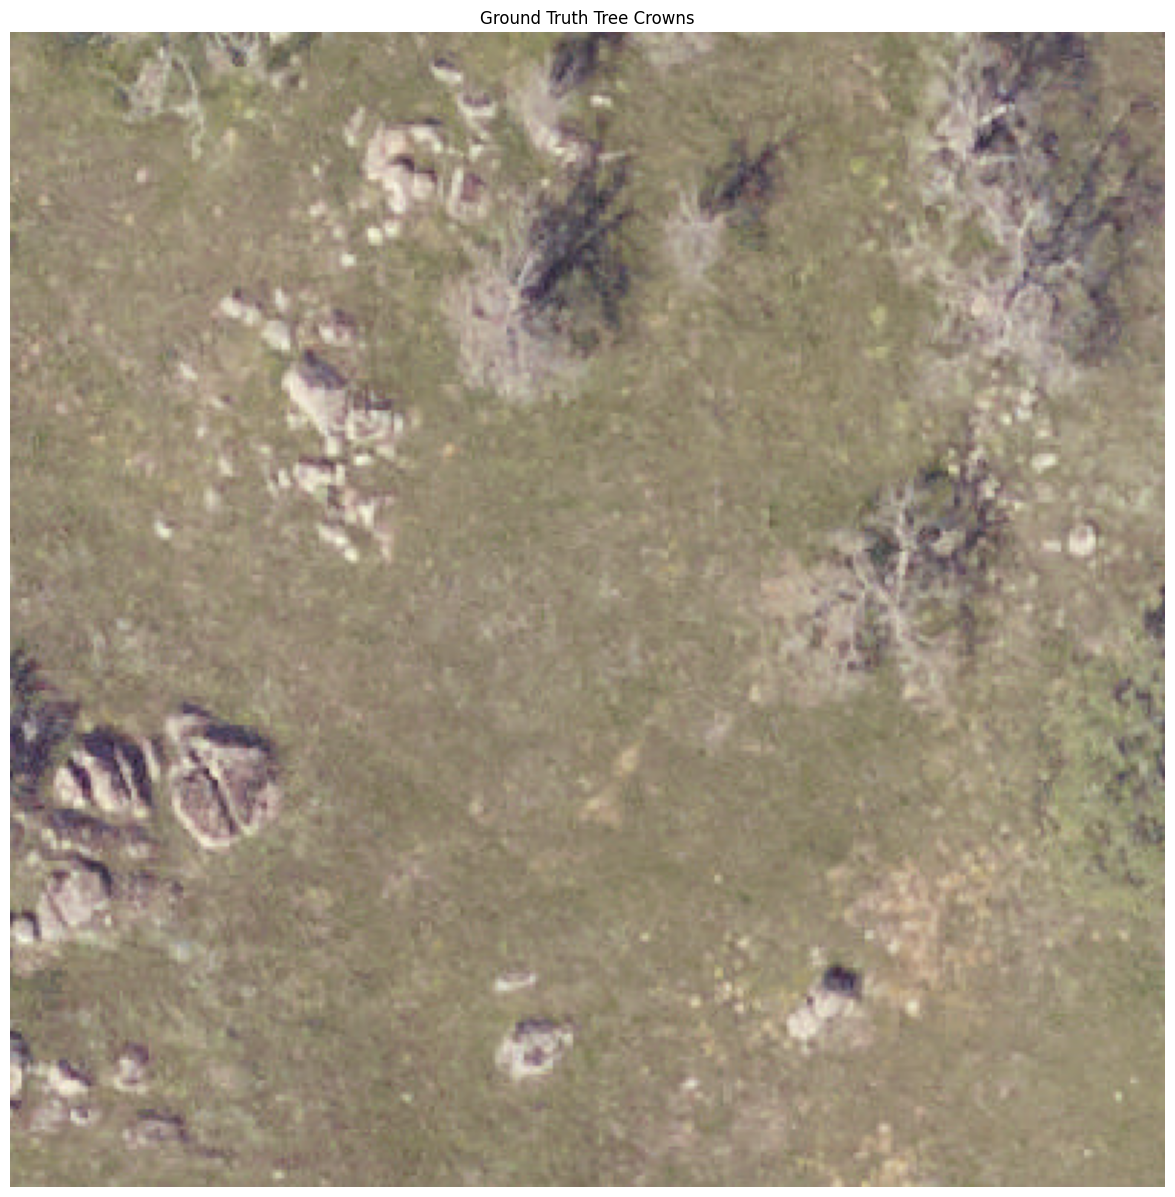

In [ ]:
raster = rasterio.open(image_path)
image = raster.read()
image = np.rollaxis(image, 0, 3)  # (bands, height, width) → (height, width, bands)

def plot_predictions(image, boxes_df, color=(255, 255, 0), thickness=2):
    img_copy = image.copy()
    for _, row in boxes_df.iterrows():
        pt1 = (int(row['xmin']), int(row['ymin']))
        pt2 = (int(row['xmax']), int(row['ymax']))
        cv2.rectangle(img_copy, pt1, pt2, color, thickness)
    return img_copy

annotated_image = plot_predictions(image, df)

plt.figure(figsize=(15, 15))
plt.imshow(annotated_image)
plt.axis("off")
plt.title("Ground Truth Tree Crowns")
plt.show()

In [10]:
model = main.deepforest()
model.use_release()

# Set training parameters
model.config["train"]["csv_file"] = "/Users/ishaangosain/Desktop/pipeline/deepforest_annotations.csv"
#model.config["train"]["root_dir"] = "/Users/ishaangosain/Desktop/pipeline/data/"
model.config["train"]["epochs"] = 3
model.config["train"]["batch_size"] = 2

# Train model
model.train()

Reading config file: /Users/ishaangosain/miniforge3/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/ishaangosain/miniforge3/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


deepforest(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias

In [12]:
import torch

# Save model's state dict
torch.save(model.model.state_dict(), "/Users/ishaangosain/Desktop/pipeline/models/fine_tuned_model.pkl")
print("✅ Model state_dict saved at /Users/ishaangosain/Desktop/pipeline/models")


✅ Model state_dict saved at /Users/ishaangosain/Desktop/pipeline/models


In [16]:
# raster_path_1 = "/content/drive/MyDrive/test/RGB/2018_SJER_3_252000_4104000_image_628.tif"  # Replace with actual path

# Predict crowns and visualize
predicted_raster = model.predict_tile(
    "/Users/ishaangosain/Desktop/pipeline/data/redwood_area_04.tif",
    return_plot=True,            # Returns an image with bounding boxes
    patch_size=1000,             # Size of sliding window
    patch_overlap=0.25,          # Overlap between patches
    color=(255, 255, 0),         # Yellow boxes
    thickness=2                  # Line thickness
)

# Show plot
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.axis("off")
plt.title("Predicted Tree Crowns")
plt.show()


Predicting: |          | 0/? [00:00<?, ?it/s]

435 predictions in overlapping windows, applying non-max supression
267 predictions kept after non-max suppression


In [ ]:
# metrics = model.evaluate(
#     "/content/drive/MyDrive/test/deepforest_annotations.csv",
#     "/content/drive/MyDrive/test/RGB/"
# )

# print("\n✅ Evaluation Metrics:")
# for k, v in metrics.items():
#     print(f"{k}: {v}")
